# Python Script to Get Raw Claims for a Chosen GraphCat ID, Group, and SubGroup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import great_expectations as ge
import ipywidgets as widgets  # library for creating widgets for jupyter notebooks
from ipywidgets import interact, interactive, fixed, interact_manual
import time
from pathlib import Path
from win10toast import ToastNotifier
import os
import pyodbc  # used for connecting to ODBC data sources
import pandas as pd  # data analysis library
plt.rcParams['figure.figsize'] = [12, 8]
pd.options.display.max_rows=1000
pd.options.display.max_columns=100

### RVMS Database Credentials:

In [2]:
userid_rvms = os.environ['windowsuser']
pw_rvms     = os.environ['windowspwd']
dsn_rvms = 'HDC-SQLP-RVMS'

### Query to obtain list of GraphCat Groups and their Sub-Groups:

In [3]:
%%time

cnxn_string = 'DSN=' + dsn_rvms + ';UID=' + userid_rvms + ';PWD=' + pw_rvms

cnxn = pyodbc.connect(cnxn_string)
cursor = cnxn.cursor()

# Copy/Paste your SQL text here
sql = """
SELECT
    MQ_GRPS.GRP_ID,
    MQ_GRPS.GRP_NM,
    MQ_SUBGRPS.SUBGRP_ID,
    MQ_SUBGRPS.SUBGRP_NM

FROM
    dbo.tbl_MQ_GRPKEYS AS MQ_GRPKEYS

    LEFT JOIN dbo.tbl_MQ_GRPS AS MQ_GRPS ON
    MQ_GRPKEYS.GRP_ID = MQ_GRPS.GRP_ID

    LEFT JOIN dbo.tbl_MQ_SUBGRPS AS MQ_SUBGRPS ON
    MQ_GRPKEYS.SUBGRP_ID = MQ_SUBGRPS.SUBGRP_ID
    """

gc_group_subgroup = pd.read_sql(sql, cnxn, index_col=None)

# For large data (data > RAM, use chunking):
"""
for c in pd.read_sql(sql, cnxn, chunksize=10000):
    c.to_csv(r'D:\temp\resultset.csv', index=False, mode='a')"""

# Close connections
cursor.close()
cnxn.close()

Wall time: 535 ms


In [4]:
gc_group_subgroup.head()

,GRP_ID,GRP_NM,SUBGRP_ID,SUBGRP_NM
0,1,Chassis,1,ABS/TCS/VSA/BSC
1,1,Chassis,2,Alignment/Drift/SWOC
2,1,Chassis,7,Brake Judder
3,1,Chassis,8,Brake Noise
4,1,Chassis,9,Brake Pipes/hoses


### Create unique list of GraphCat groups and subgroups to be used for GUI controls

In [5]:
group_list = sorted(gc_group_subgroup['GRP_NM'].unique().tolist())

In [6]:
subgroup_list = sorted(gc_group_subgroup['SUBGRP_NM'].unique().tolist())

In [7]:
group_list

['Chassis',
 'Denso',
 'Engine',
 'Exterior',
 'Interior',
 'OBD',
 'Other',
 'Transmission']

In [8]:
subgroup_list

['ABS/TCS/VSA/BSC',
 'ATF Cooling',
 'Alignment/Drift/SWOC',
 'Audio',
 'Battery',
 'Body',
 'Brake Judder',
 'Brake Noise',
 'Brake Pipes/hoses',
 'Bulbs',
 'Bumper Paint',
 'Bumpers',
 'CVT Trans',
 'Calipers/Disk/Drums/Pads',
 'Catalytic Converter',
 'Center Console',
 'Center Module',
 'Charging System',
 'Clutch',
 'Combimeter',
 'Conventional Brakes (pedal/booster)',
 'Cooling System',
 'Cruise Control',
 'Cup Holder',
 'Cylinder Head',
 'Dampers',
 'Diff, Transf Controls',
 'Door Liner',
 'Door Systems',
 'Drive Shaft',
 'ECU/PCM/TCM',
 'EGR System',
 'Engine Block',
 'Engine Trim',
 'Engine Wiring',
 'Evap System Component',
 'Exhaust Manifold',
 'Exterior Trim',
 'Fender Cladding',
 'Floor Covering/Carpet',
 'Front Light Housing',
 'Front Seats',
 'Fuel Pump',
 'Fuel Sending Unit',
 'Fuel System',
 'Fuel Tank',
 'Gear Shifter/Select Lever',
 'General Trans',
 'Glass',
 'Glove Box',
 'HVAC',
 'HVAC Vents',
 'Hand/cable Brakes',
 'Hard Start',
 'Harness',
 'Headliner',
 'Hood/Fu

### Create a list of GraphCat Descriptions at GraphCat Level

In [9]:
%%time

cnxn_string = 'DSN=' + dsn_rvms + ';UID=' + userid_rvms + ';PWD=' + pw_rvms

cnxn = pyodbc.connect(cnxn_string)
cursor = cnxn.cursor()

# Copy/Paste your SQL text here
sql = """
SELECT
    DISTINCT
    GC_MASTER.GraphCatID,
    GC_MASTER.GraphCatDesc,
    GC_MASTER.GraphCatType,
    CONCAT(CAST(GC_MASTER.GraphCatID as VARCHAR), ' - ', GC_MASTER.GraphCatDesc) AS GraphCat

FROM
    dbo.tbl_GraphCatMaster as GC_MASTER

WHERE
    GC_MASTER.GraphCatType = 'R'
    AND GC_MASTER.GraphCatDesc like 'R %'
    """

gc_list = pd.read_sql(sql, cnxn, index_col=None)

# For large data (data > RAM, use chunking):
"""
for c in pd.read_sql(sql, cnxn, chunksize=10000):
    c.to_csv(r'D:\temp\resultset.csv', index=False, mode='a')"""

# Close connections
cursor.close()
cnxn.close()

Wall time: 188 ms


In [10]:
gc_list.head()

,GraphCatID,GraphCatDesc,GraphCatType,GraphCat
0,1,R MAP TL 2001 KA,R,1 - R MAP TL 2001 KA
1,2,R MAP TL 2001 KC,R,2 - R MAP TL 2001 KC
2,3,R MAP TL 2001 KJ,R,3 - R MAP TL 2001 KJ
3,4,R MAP CL 2001 KA,R,4 - R MAP CL 2001 KA
4,5,R MAP CL 2001 KC,R,5 - R MAP CL 2001 KC


### Could not find an easy solution to split delimited string into multiple columns using native SQL Server SQL, so resorted to using Python functions:

In [11]:
def getModelYear(row) -> str:
    word_token = row['GraphCatDesc'].split()
    
    model_year = word_token[3]
    
    if model_year.isdigit():
        return model_year
    else:
        return word_token[4]
        

def getFactoryCode(row) -> str:
    word_token = row['GraphCatDesc'].split()
    factory_code = word_token[1]
    
    return factory_code.upper()

def getModelName(row) -> str:
    word_token = row['GraphCatDesc'].split()
    model_name = word_token[2]
    
    return model_name.upper()

### Add Model Year, Factory, and Model Name columns

In [12]:
gc_list['ModelYear'] = gc_list.apply(getModelYear, axis='columns')
gc_list['Factory'] = gc_list.apply(getFactoryCode, axis='columns')
gc_list['ModelName'] = gc_list.apply(getModelName, axis='columns')

In [13]:
gc_list.head()

,GraphCatID,GraphCatDesc,GraphCatType,GraphCat,ModelYear,Factory,ModelName
0,1,R MAP TL 2001 KA,R,1 - R MAP TL 2001 KA,2001,MAP,TL
1,2,R MAP TL 2001 KC,R,2 - R MAP TL 2001 KC,2001,MAP,TL
2,3,R MAP TL 2001 KJ,R,3 - R MAP TL 2001 KJ,2001,MAP,TL
3,4,R MAP CL 2001 KA,R,4 - R MAP CL 2001 KA,2001,MAP,CL
4,5,R MAP CL 2001 KC,R,5 - R MAP CL 2001 KC,2001,MAP,CL


### Get input from user to limit GraphCats to certain model years and models

In [14]:
years_str = input("Enter one or more model years separated by comma: ").replace(' ', '')
models_str = input("Enter one or more model names separated by comma: ").replace(' ', '').upper()

years_list = years_str.split(',')
models_list = models_str.split(',')

Enter one or more model years separated by comma: 2015
Enter one or more model names separated by comma: crv


In [15]:
models = '|'.join(models_list)

In [16]:
models

'CRV'

In [17]:
year_criteria = gc_list['ModelYear'].isin(years_list)
model_criteria = gc_list['ModelName'].str.contains(models)

In [18]:
gc_list_final = gc_list[(year_criteria) & (model_criteria)]

In [19]:
graphcats = gc_list_final['GraphCat'].tolist()

In [20]:
graphcats

['1074 - R ELP CRV 2015 2WD KA',
 '1075 - R ELP CRV 2015 4WD KA',
 '1076 - R ELP CRV 2015 4WD KC',
 '1126 - R HCM CRV 2015 2WD KA',
 '1127 - R HCM CRV 2015 4WD KA',
 '1128 - R HCM CRV 2015 2WD KC',
 '1129 - R HCM CRV 2015 4WD KC',
 '1377 - R HDM CRV 2015 KA KL',
 '1378 - R HDM CRV 2015 KK KM',
 '1379 - R HDM CRV 2015 KX']

In [21]:
graphcats

['1074 - R ELP CRV 2015 2WD KA',
 '1075 - R ELP CRV 2015 4WD KA',
 '1076 - R ELP CRV 2015 4WD KC',
 '1126 - R HCM CRV 2015 2WD KA',
 '1127 - R HCM CRV 2015 4WD KA',
 '1128 - R HCM CRV 2015 2WD KC',
 '1129 - R HCM CRV 2015 4WD KC',
 '1377 - R HDM CRV 2015 KA KL',
 '1378 - R HDM CRV 2015 KK KM',
 '1379 - R HDM CRV 2015 KX']

### Query to obtain raw claims by GraphCatID, Group, and SubGroup:

In [22]:
%%time

gc_list = widgets.SelectMultiple(
    options=graphcats,
    index=list(range(len(graphcats))),
    rows=20,
    description='GraphCats',
    disabled=False
)
display(gc_list)

def getRawClaimsByGroupSubGroup(group=group_list, subgroup=subgroup_list):
    cnxn_string = 'DSN=' + dsn_rvms + ';UID=' + userid_rvms + ';PWD=' + pw_rvms

    cnxn = pyodbc.connect(cnxn_string)
    cursor = cnxn.cursor()
    
    gc_id_list = gc_list.value
    number_of_gc = len(gc_id_list)

    # Copy/Paste your SQL text here
    sql = """
    WITH GC_GROUP_SUBGRP AS (

    SELECT
        MQ_GRPS.GRP_ID,
        MQ_GRPS.GRP_NM,
        MQ_SUBGRPS.SUBGRP_ID,
        MQ_SUBGRPS.SUBGRP_NM

    FROM
        dbo.tbl_MQ_GRPKEYS AS MQ_GRPKEYS

        LEFT JOIN dbo.tbl_MQ_GRPS AS MQ_GRPS ON
        MQ_GRPKEYS.GRP_ID = MQ_GRPS.GRP_ID

        LEFT JOIN dbo.tbl_MQ_SUBGRPS AS MQ_SUBGRPS ON
        MQ_GRPKEYS.SUBGRP_ID = MQ_SUBGRPS.SUBGRP_ID


    ),

    RESERVE_GC_MTC AS (

    SELECT
        GC_MTC.GraphCatID,
        GC_MTC.MTC_Model,
        GC_MTC.MTC_Type,
        GC_MTC.MTC_Option,
        GC_MASTER.GraphCatDesc,
        GC_MASTER.GraphCatType


    FROM
        RVMS.dbo.tbl_GraphCat_MTC as GC_MTC

        LEFT JOIN dbo.tbl_GraphCatMaster AS GC_MASTER ON
        GC_MTC.GraphCatID = GC_MASTER.GraphCatID

    WHERE
        GC_MASTER.GraphCatType = 'R'

    )


    SELECT
        RESERVE_GC_MTC.GraphCatID,
        RESERVE_GC_MTC.GraphCatDesc,
        RESERVE_GC_MTC.GraphCatType,
        CLA1_FINAL.*,
        CLA1_FINAL.WAR_EXCH_RATE_AMT * CLA1_FINAL.WAR_TOTAL_CHG_AMT as WAR_TOTAL_CHG_AMT_USD,
        SUBSTRING(CLA1_FINAL.SERVICE_PART_NO, 1, 5) AS PART5,
        GC_GROUP_SUBGRP.GRP_NM,
        GC_GROUP_SUBGRP.SUBGRP_NM

    FROM
        RVMS.dbo.war_wrcla1_final as CLA1_FINAL

        LEFT JOIN GC_GROUP_SUBGRP AS GC_GROUP_SUBGRP ON
        CLA1_FINAL.GRP_ID = GC_GROUP_SUBGRP.GRP_ID
        AND CLA1_FINAL.SUBGRP_ID = GC_GROUP_SUBGRP.SUBGRP_ID

        LEFT JOIN RESERVE_GC_MTC as RESERVE_GC_MTC ON
        CLA1_FINAL.MTC_MODEL = RESERVE_GC_MTC.MTC_Model
        AND CLA1_FINAL.MTC_TYPE = RESERVE_GC_MTC.MTC_Type
        AND CLA1_FINAL.MTC_OPTION = RESERVE_GC_MTC.MTC_Option

    WHERE
        CLA1_FINAL.CAMPAIGN_CODE = 'N'
        AND RESERVE_GC_MTC.GraphCatID IN(%s)
        AND GC_GROUP_SUBGRP.GRP_NM = ?
        AND GC_GROUP_SUBGRP.SUBGRP_NM = ?
        """ % (",".join("?" * number_of_gc))
        
        
    parameter_list = []
    for id in gc_id_list:
        parameter_list.append(int(id.split(' ')[0]))
        
        
    parameter_list.append(group)
    parameter_list.append(subgroup)

    global raw_claims_group_subgroup
    raw_claims_group_subgroup = pd.read_sql(sql, cnxn, index_col=None, params=parameter_list)
    
    print("Removing any funky characters from the dataframe (if any)...")
    raw_claims_group_subgroup = raw_claims_group_subgroup.applymap(lambda x: x.encode('unicode_escape').
                 decode('utf-8') if isinstance(x, str) else x)
    
    print("Number of (rows, columns): ", raw_claims_group_subgroup.shape)

    # For large data (data > RAM, use chunking):
    """
    for c in pd.read_sql(sql, cnxn, chunksize=10000):
        c.to_csv(r'D:\temp\resultset.csv', index=False, mode='a')"""

    # Close connections
    cursor.close()
    cnxn.close()
    
    print('SQL parameters: ', parameter_list)

interact_manual(getRawClaimsByGroupSubGroup);

SelectMultiple(description='GraphCats', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), options=('1074 - R ELP CRV 2015 …

interactive(children=(Dropdown(description='group', options=('Chassis', 'Denso', 'Engine', 'Exterior', 'Interi…

Wall time: 175 ms


In [24]:
raw_claims_group_subgroup.head()

,GraphCatID,GraphCatDesc,GraphCatType,DEALER_NO_CLA,WAR_CLAIM_NO_CLA,DEALER_NO,WAR_CLAIM_NO,REPR_ORDER_YEAR_NO,REPAIR_ORDER_DATE,VEH_SALE_DATE,VIN,WAR_PARTS_CHG_AMT,WAR_TOTAL_CHG_AMT,WAR_EXCH_RATE_AMT,WAR_RESP_DISTR_CDE,WAR_PROD_DISTR_CDE,WAR_ORIG_DISTR_CDE,WAR_CLAIM_DATE,WAR_CLAIM_SUF_NO,VEHICLE_DESTN_CODE,CAMPAIGN_CODE,WAR_DEFECT_CODE,WAR_DEF_DESC_TEXT,REVISION_SEQ_NO,SERVICE_PART_NO,GRP_ID,SUBGRP_ID,AF_MTH,RO_MTH,SALE_MTH,ENG_SIZE,MTC_MODEL,MTC_TYPE,MTC_OPTION,CONTDESC,AHM_ECU_FAIL_CODE,PRI_LABOR_OP_CODE,CUST_CONT_CODE,MONTHS_IN_SERVICE,UPDATE_TSTP,ORIG_DEFECT_CODE,REPAIR_METHOD,WAR_TOTAL_CHG_AMT_USD,PART5,GRP_NM,SUBGRP_NM
0,1129,R HCM CRV 2015 4WD KC,R,07711000,W889041000,711000,889041,2017,2017-08-15,2015-04-28,2HKRM4H39FH114222,0.0,37.98,0.799199,140,140,130,201709,0,KC,N,09999,OTHER ...,0,44305T1WA01,1,30,2015 - 02,2017 - 08,2015 - 04,None,FTFE,CA5,,None,None,None,None,28,2017-10-31,09999,None,30.353570,44305,Chassis,Drive Shaft
1,1129,R HCM CRV 2015 4WD KC,R,03131000,W267901000,131000,267901,2017,2017-08-16,2015-09-16,2HKRM4H38FH123395,7.0,105.40,0.799199,140,140,130,201709,0,KC,N,00401,DISTORTED ...,0,91205P0X005,1,30,2015 - 06,2017 - 08,2015 - 09,None,FTFE,CA5,,None,None,None,None,23,2017-10-31,00401,None,84.235554,91205,Chassis,Drive Shaft
2,1129,R HCM CRV 2015 4WD KC,R,03131000,W430581000,131000,430581,2018,2018-06-13,2015-06-19,2HKRM4H32FH120041,88.0,1079.10,0.753929,140,140,130,201806,0,KC,N,01102,DETERIORATED ...,0,912075LJ003,1,30,2015 - 04,2018 - 06,2015 - 06,None,FTFE,CA5,,None,None,None,None,36,2018-07-31,01102,None,813.565313,91207,Chassis,Drive Shaft
3,1129,R HCM CRV 2015 4WD KC,R,07752000,W331231000,752000,331231,2018,2018-06-11,2015-08-31,2HKRM4H31FH123366,106.0,869.36,0.753929,140,140,130,201806,0,KC,N,07408,IMPROPERLY SEALED ...,0,912075LJ003,1,30,2015 - 06,2018 - 06,2015 - 08,None,FTFE,CA5,,None,None,None,None,34,2018-07-31,07408,None,655.436141,91207,Chassis,Drive Shaft
4,1129,R HCM CRV 2015 4WD KC,R,07735000,W305521000,735000,305521,2017,2017-10-30,2014-12-01,2HKRM4H36FH104439,81.0,822.93,0.808245,140,140,130,201711,0,KC,N,07408,IMPROPERLY SEALED ...,0,912075LJ003,1,30,2014 - 11,2017 - 10,2014 - 12,None,FTFE,CA5,,None,None,None,None,35,2018-02-19,07408,None,665.128903,91207,Chassis,Drive Shaft


### Total Charge Amount in USD

In [ ]:
raw_claims_group_subgroup['WAR_TOTAL_CHG_AMT_USD'].sum()

### Total Charge Amount in Native Currency

In [ ]:
raw_claims_group_subgroup['WAR_TOTAL_CHG_AMT'].sum()

### Claim Qty by RO Month

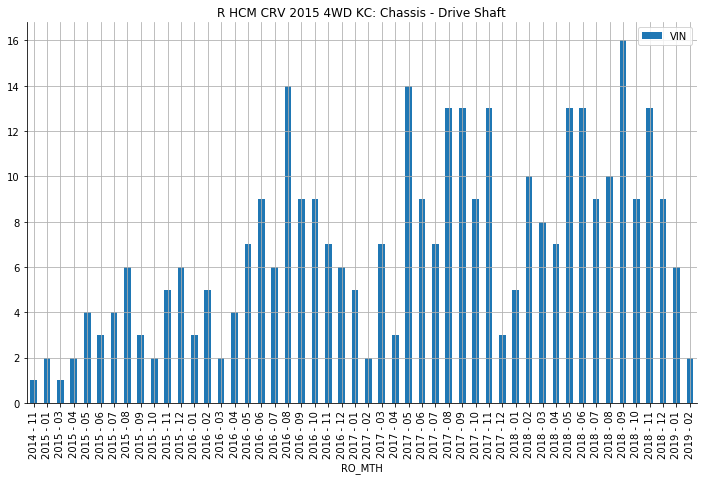

In [25]:
plt.rcParams['figure.figsize'] = [12, 7]
raw_claims_group_subgroup.pivot_table(index='RO_MTH', values='VIN', aggfunc='count').plot.bar()
plt.title(raw_claims_group_subgroup['GraphCatDesc'].values[0] + ': ' + raw_claims_group_subgroup['GRP_NM'].values[0] + ' - ' 
          + raw_claims_group_subgroup['SUBGRP_NM'].values[0])
plt.grid(True)
sns.despine();

### Claim Qty by AF Month

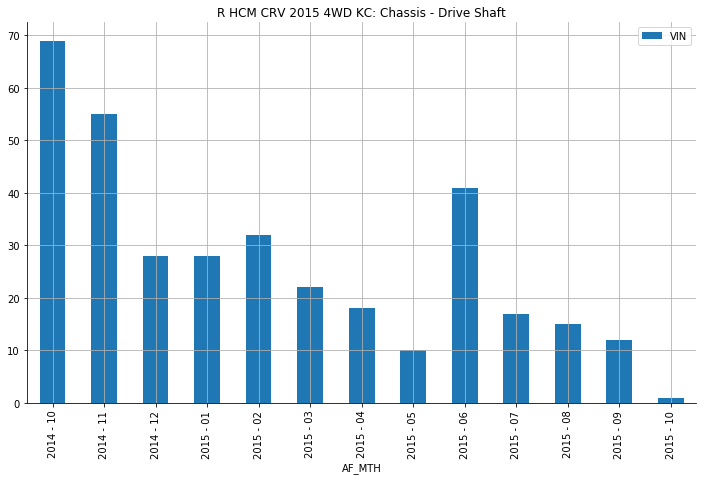

In [26]:
raw_claims_group_subgroup.pivot_table(index='AF_MTH', values='VIN', aggfunc='count').plot.bar()
plt.title(raw_claims_group_subgroup['GraphCatDesc'].values[0] + ': ' + raw_claims_group_subgroup['GRP_NM'].values[0] + ' - ' 
          + raw_claims_group_subgroup['SUBGRP_NM'].values[0])
plt.grid(True)
sns.despine();

#### Top Claimed Part #s

In [ ]:
raw_claims_group_subgroup.pivot_table(index='PART5', values='VIN', aggfunc='count').sort_values(by='VIN', ascending=False)

In [27]:
raw_claims_group_subgroup.to_excel(r'D:\temp\Raw_Claims.xlsx', index=False)